# Discharge Notes and Readmission Rates: NLP

This notebook is for the processing the cleaned dataset through a NLP.

## Import

Import the relevant libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

#modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xg
from sklearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.utils import class_weight

# Neural network models and layers
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    array_to_img,
    img_to_array,
    load_img
)
from tensorflow.keras.models import load_model

## Functions

In [2]:
def scores(model, X, y, set_type):
    '''
    This function takes in an already fitted model, X, y, and
    the type of data (train, validation, or test) in str format,
    and prints out the accuracy and recall scores. The function
    also prints out the confusion matrix
    '''
    pred = model.predict(X)
    acc_score = accuracy_score(y, pred)
    rec_score = recall_score(y, pred)
    
    print("{} Scores".format(set_type))
    print("accuracy: ", acc_score)
    print("recall:   ", rec_score)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_title(set_type)
    plot_confusion_matrix(model, X, y, ax=ax)
    return round(acc_score*100,1), round(rec_score*100,1) 

In [3]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

In [4]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Readmission', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()
    return fig

## Reading in the Data

Here, I read in the cleand dataset from the previous EDA folder.

In [5]:
df = pd.read_csv('data/admissions_cleaned_3.csv.gz', compression='gzip')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47463 entries, 0 to 47462
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ADMISSION_TYPE      47463 non-null  object
 1   ADMISSION_LOCATION  47463 non-null  object
 2   DISCHARGE_LOCATION  47463 non-null  object
 3   INSURANCE           47463 non-null  object
 4   LANGUAGE            47463 non-null  object
 5   RELIGION            47463 non-null  object
 6   MARITAL_STATUS      47463 non-null  object
 7   ETHNICITY           47463 non-null  object
 8   DIAGNOSIS           47463 non-null  object
 9   READMISSION         47463 non-null  int64 
 10  GENDER              47463 non-null  object
 11  AGE                 47463 non-null  int64 
 12  TEXT                47463 non-null  object
 13  CPT_CD              47463 non-null  object
 14  DIAG_ICD9_CODE      47460 non-null  object
 15  DRG_CODE            47463 non-null  object
 16  PROCED_ICD9_CODE    47

In [7]:
df['READMISSION'].value_counts()

0    44453
1     3010
Name: READMISSION, dtype: int64

In [8]:
#set X as the text data, and y as the readmission status
X = df['TEXT']
y = df['READMISSION']

The dataset is heavily imbalanced, with a lot more negative cases. In order to handle class imbalance, I will later on use two method, SMOTE and undersampling, to mitigate the class imbalance.

## Train, Validation, and Test Split

I split the data set into three sets: Train, Validation, and Test.
The ratio I used was 70:15:15.

In [9]:
X_train, X_v_t, y_train, y_v_t = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [10]:
X_val, X_test, y_val, y_test = train_test_split(X_v_t, y_v_t, test_size=0.50, random_state=42, stratify=y_v_t)

In [11]:
X_train.shape

(33224,)

## Pipeline Parameters

In this section, I set specific pipeline parameters that I will keep constant throughout the project.

In [12]:
sw = stopwords.words('english')

#setting the number of maximum features as 10% of rows in X
max_feats = int(X_train.shape[0]*0.10)

## Modeling

In this section, I will run several different models. Once I decide the best model, I will export the results out so that in another notebook, I can merge that results to other data features and run that through models again to see if I can get a better model.

### Model 0: Dummy Classification

For my Model 0, I run a simple dummy classifier. I test out both a count vectorizer and a tfidf vectorizer to see if it will impact the results. I have yet to do anything about the class imbalance.

* Model: Dummy
* Vectorizer: Count
* Class Imbalance Solution: None

In [13]:
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats)),
    ('dummy', DummyClassifier(random_state=42, strategy="stratified"))
    ])

Train Scores
accuracy:  0.8804177702865399
recall:    0.06027527289985762
Validation Scores
accuracy:  0.8808821463688721
recall:    0.06873614190687362
Test Scores
accuracy:  0.8810393258426966
recall:    0.07079646017699115


(88.1, 7.1)

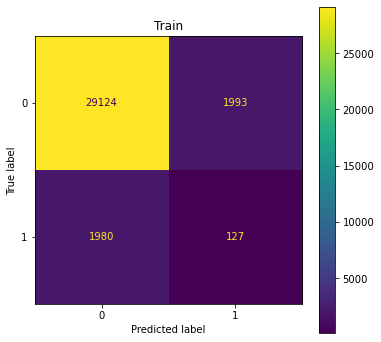

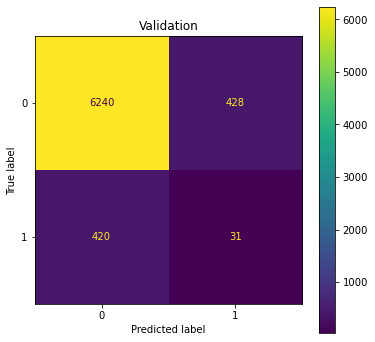

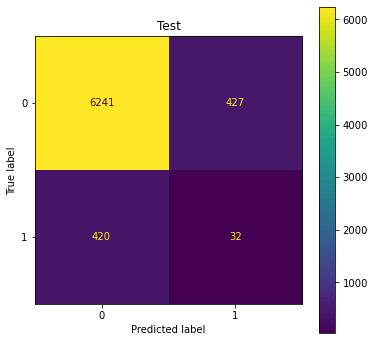

In [14]:
pp_count.fit(X_train, y_train)

scores(pp_count, X_train, y_train, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

* Model: Dummy
* Vectorizer: Tfidf
* Class Imbalance Solution: None

In [15]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats)),
    ('dummy', DummyClassifier(random_state=42, strategy="stratified")),   
    ])

Train Scores
accuracy:  0.8804177702865399
recall:    0.06027527289985762
Validation Scores
accuracy:  0.8808821463688721
recall:    0.06873614190687362
Test Scores
accuracy:  0.8810393258426966
recall:    0.07079646017699115


(88.1, 7.1)

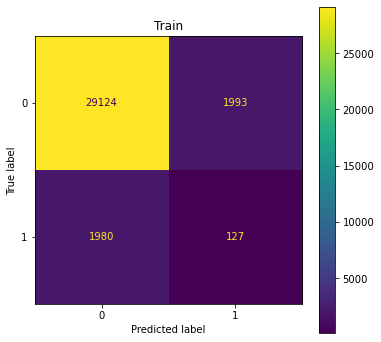

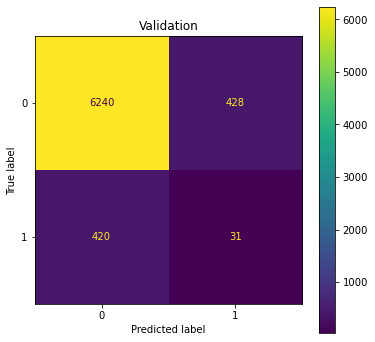

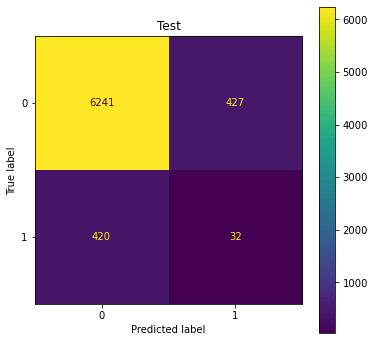

In [16]:
pp_tfidf.fit(X_train, y_train)

scores(pp_tfidf, X_train, y_train, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

Though the accuracy is high for both the vectorizers through the dummy classifier model, the recall score was very poor. This is most likely due to the class imbalance. However, I will run a non-dummy, but simple logistic regression model to validate that the low recall score is not because of the dummy model itself.

### Model 1: Logistic Regression

The next model I decided to use is the logitic regression model.

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: None

In [ ]:
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

In [ ]:
pp_count.fit(X_train, y_train)

scores(pp_count, X_train, y_train, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: None

In [ ]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

In [ ]:
pp_tfidf.fit(X_train, y_train)

scores(pp_tfidf, X_train, y_train, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

Again, the accuracy scores are high, but the recall scores are poor. Thus, for the next modeling step, I will try to improve the model by first trying to mitigate the class imbalance.

### Handling Imbalanced Data 

As mentioned before, the dataset is heavily imbalanced. I will implement three methods to handle the class imbalance:
* Undersample the negative cases
* Pass in class weights
* Implement SMOTE

#### Undersampling Negative Cases: 1 to 1

In [ ]:
#concat the train dataset together
train_df = pd.concat([y_train, X_train], axis=1)

In [ ]:
#split the positive and negative data
train_df_pos = train_df[train_df['READMISSION']==1]
train_df_neg = train_df[train_df['READMISSION']==0]

In [ ]:
#take a sample of the negative training set with the same number of rows as positive dataset
train_df_neg_samp = train_df_neg.sample(n=len(train_df_pos), random_state=42)

In [ ]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_train_df = pd.concat([train_df_pos,train_df_neg_samp],axis=0)

In [ ]:
#randomize the new dataset
new_train_df = new_train_df.sample(n=len(new_train_df), random_state=42)

In [ ]:
#split out the X and y of the new dataset
y_train_1 = new_train_df['READMISSION']
X_train_1 = new_train_df['TEXT']
max_feats_1 = int(X_train_1.shape[0]*0.10)

#### Undersampling Negative Cases: 2 to 1

In [ ]:
#concat the train dataset together
train_df = pd.concat([y_train, X_train], axis=1)

In [ ]:
#split the positive and negative data
train_df_pos = train_df[train_df['READMISSION']==1]
train_df_neg = train_df[train_df['READMISSION']==0]

In [ ]:
#take a sample of the negative training set with the same number of rows as positive dataset
train_df_neg_samp = train_df_neg.sample(n=2*len(train_df_pos), random_state=42)

In [ ]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_train_df = pd.concat([train_df_pos,train_df_neg_samp],axis=0)

In [ ]:
#randomize the new dataset
new_train_df = new_train_df.sample(n=len(new_train_df), random_state=42)

In [ ]:
#split out the X and y of the new dataset
y_train_2 = new_train_df['READMISSION']
X_train_2 = new_train_df['TEXT']
max_feats_2 = int(X_train_2.shape[0]*0.10)

#### Undersampling Negative Cases: 3 to 1

In [ ]:
#concat the train dataset together
train_df = pd.concat([y_train, X_train], axis=1)

In [ ]:
#split the positive and negative data
train_df_pos = train_df[train_df['READMISSION']==1]
train_df_neg = train_df[train_df['READMISSION']==0]

In [ ]:
#take a sample of the negative training set with the same number of rows as positive dataset
train_df_neg_samp = train_df_neg.sample(n=2*len(train_df_pos), random_state=42)

In [ ]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_train_df = pd.concat([train_df_pos,train_df_neg_samp],axis=0)

In [ ]:
#randomize the new dataset
new_train_df = new_train_df.sample(n=len(new_train_df), random_state=42)

In [ ]:
#split out the X and y of the new dataset
y_train_3 = new_train_df['READMISSION']
X_train_3 = new_train_df['TEXT']
max_feats_3 = int(X_train_3.shape[0]*0.10)

#### Class Weights

In [ ]:
#calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=[0,1],y=y_train)

In [ ]:
class_weights

### Model 1.1: Logistic Regression - Undersampling

In this section, I applied the undersampled dataset to logistic regression model.

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: Undersampling Negative 1:1

In [41]:
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.7135738016136687
recall:    0.6971998101566208
Validation Scores
accuracy:  0.6481247366203119
recall:    0.623059866962306
Test Scores
accuracy:  0.6418539325842697
recall:    0.5796460176991151


(64.2, 58.0)

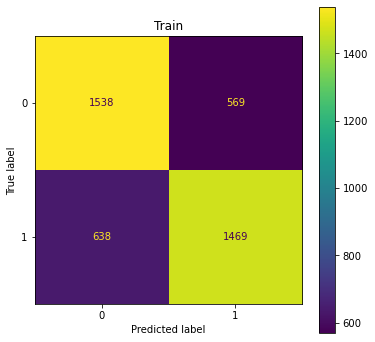

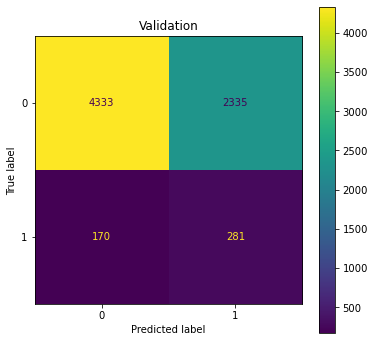

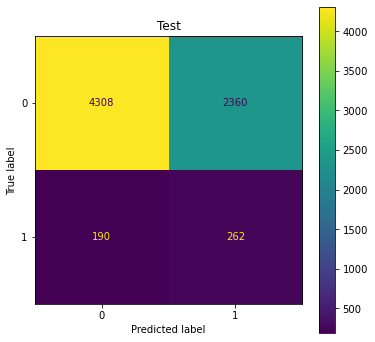

In [42]:
pp_count.fit(X_train_1, y_train_1)

scores(pp_count, X_train_1, y_train_1, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: Undersampling Negative 1:1

In [182]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

Train Scores
accuracy:  0.6995728523967727
recall:    0.7209302325581395
Validation Scores
accuracy:  0.6314089057451889
recall:    0.6940133037694013
Test Scores
accuracy:  0.6341292134831461
recall:    0.6415929203539823


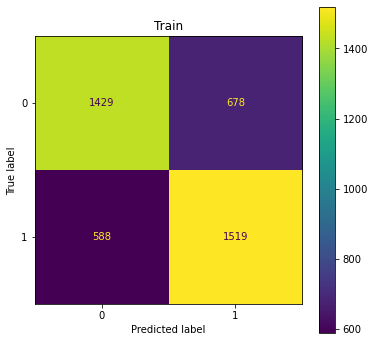

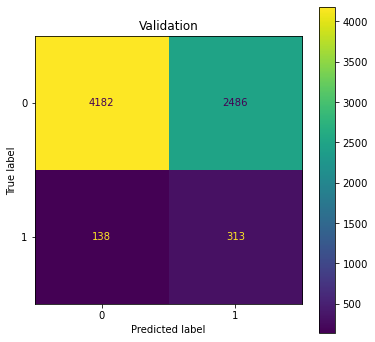

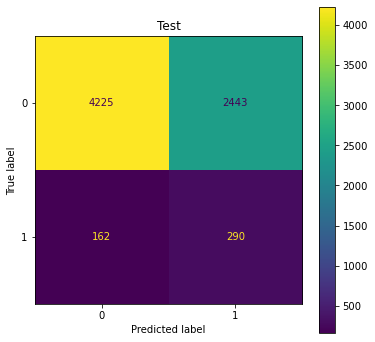

In [183]:
pp_tfidf.fit(X_train_1, y_train_1)

scores(pp_tfidf, X_train_1, y_train_1, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
log_acc, log_recall = scores(pp_tfidf, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: Undersampling Negative 2:1

In [45]:
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats_2)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.7446606549596583
recall:    0.46511627906976744
Validation Scores
accuracy:  0.8015170670037927
recall:    0.38802660753880264
Test Scores
accuracy:  0.7959269662921349
recall:    0.35176991150442477


(79.6, 35.2)

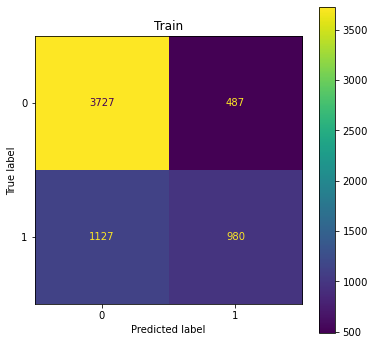

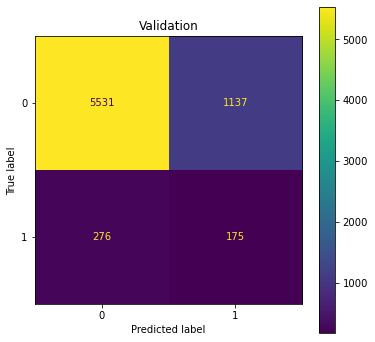

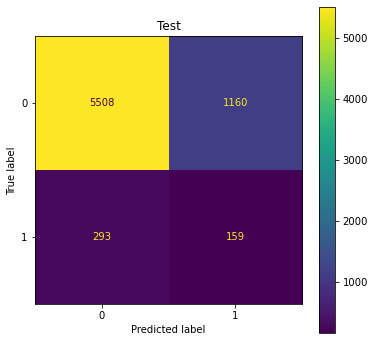

In [46]:
pp_count.fit(X_train_2, y_train_2)

scores(pp_count, X_train_2, y_train_2, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: Undersampling Negative 2:1

In [47]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_2)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

Train Scores
accuracy:  0.7229868691662712
recall:    0.3507356430944471
Validation Scores
accuracy:  0.8499789296249474
recall:    0.3436807095343681
Test Scores
accuracy:  0.8443820224719101
recall:    0.26327433628318586


(84.4, 26.3)

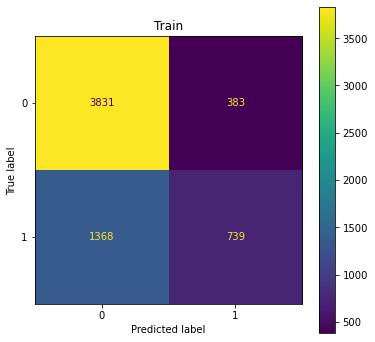

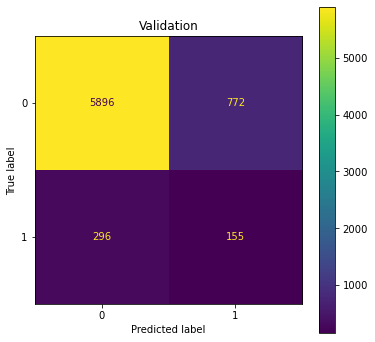

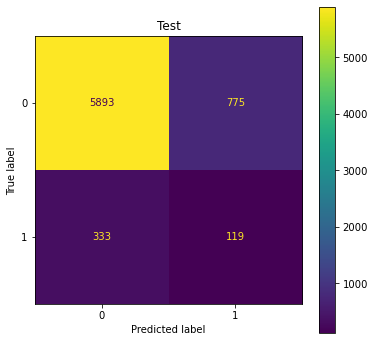

In [48]:
pp_tfidf.fit(X_train_2, y_train_2)

scores(pp_tfidf, X_train_2, y_train_2, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: Undersampling Negative 3:1

In [49]:
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats_3)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.7446606549596583
recall:    0.46511627906976744
Validation Scores
accuracy:  0.8015170670037927
recall:    0.38802660753880264
Test Scores
accuracy:  0.7959269662921349
recall:    0.35176991150442477


(79.6, 35.2)

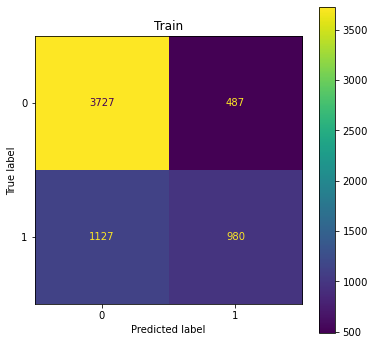

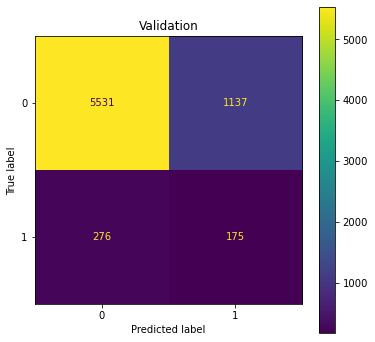

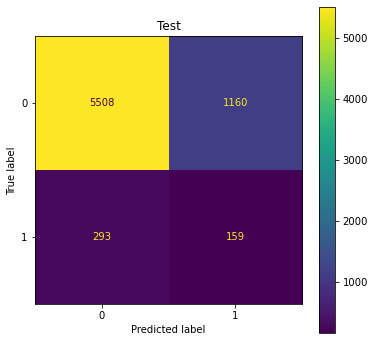

In [50]:
pp_count.fit(X_train_3, y_train_3)

scores(pp_count, X_train_3, y_train_3, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: Undersampling Negative 3:1

In [51]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_3)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

Train Scores
accuracy:  0.7229868691662712
recall:    0.3507356430944471
Validation Scores
accuracy:  0.8499789296249474
recall:    0.3436807095343681
Test Scores
accuracy:  0.8443820224719101
recall:    0.26327433628318586


(84.4, 26.3)

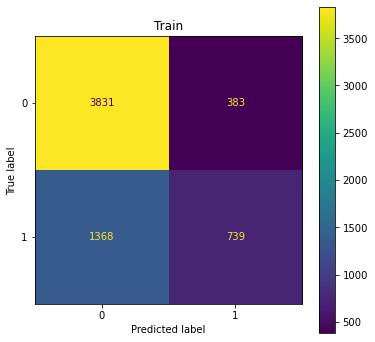

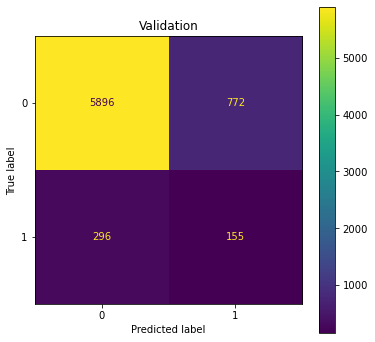

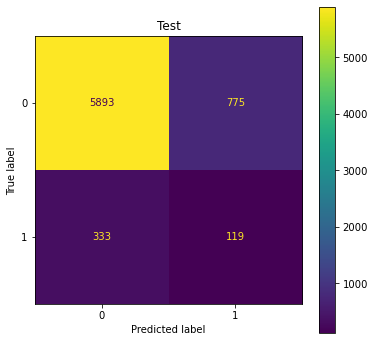

In [52]:
pp_tfidf.fit(X_train_3, y_train_3)

scores(pp_tfidf, X_train_3, y_train_3, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

After using the undersampled dataset, though the accuracy went down, the recall score went up. The ratio of 1 to 1 of negative to positive cases had the best recall scores. In addition, the tfidf vectorizer performed better than the count vectorizer, and so we will just use the tfidf vectorizer.

### Model 1.2: Logistic Regression - Class Weights

In this section, I passed in the class weights in the logistic regression model.

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: Class Weights

In [53]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats)),
    ('logreg', LogisticRegression(random_state=42, class_weight=class_weights)),   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:680: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":
/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.9369431736094389
recall:    0.006169909824394874
Validation Scores
accuracy:  0.9370698131760079
recall:    0.0066518847006651885
Test Scores
accuracy:  0.9362359550561797
recall:    0.0


(93.6, 0.0)

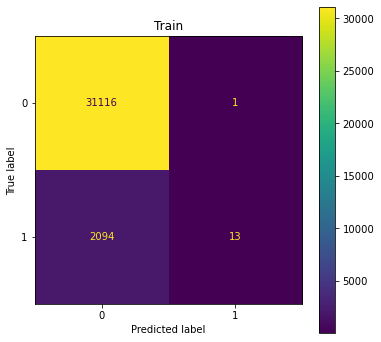

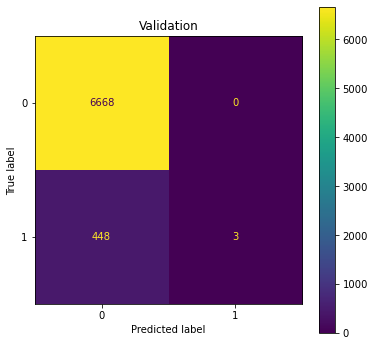

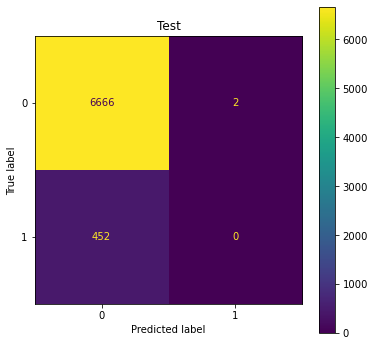

In [54]:
pp_tfidf.fit(X_train, y_train)

scores(pp_tfidf, X_train, y_train, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

As seen above, passing in the class weights did not improve the recall score.

### Model 1.3: Logistic Regression - SMOTE

In this section, I utilized SMOTE to oversample the imbalanced class.

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: SMOTE

In [55]:
pp_tfidf = imbpipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats)),
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(random_state=42))   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.8008367445220322
recall:    0.7489321309919317
Validation Scores
accuracy:  0.7652760219131901
recall:    0.49223946784922396
Test Scores
accuracy:  0.7625
recall:    0.49557522123893805


(76.2, 49.6)

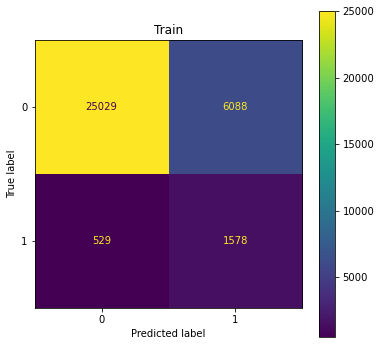

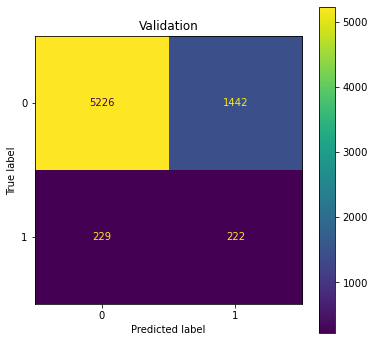

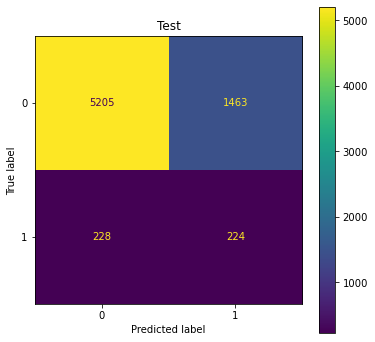

In [56]:
pp_tfidf.fit(X_train, y_train)

scores(pp_tfidf, X_train, y_train, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

SMOTE did improve the recall score. However, running SMOTE into grid search will take too much computation power. In addition, it led to the model overfitting. Therefore, I will not utilize SMOTE.

### Introducing N-Grams

I wanted to test if introducing n-grams into the data to see if it improves the score.

In [57]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1, ngram_range=(1,3))),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

Train Scores
accuracy:  0.6865211200759374
recall:    0.7090650213573801
Validation Scores
accuracy:  0.6253687315634219
recall:    0.6962305986696231
Test Scores
accuracy:  0.6252808988764045
recall:    0.6548672566371682


(62.5, 65.5)

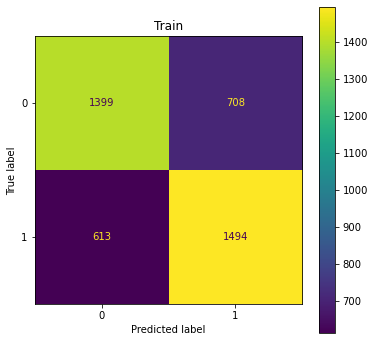

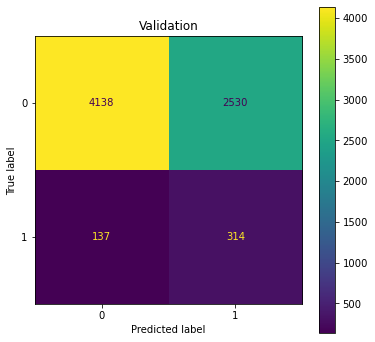

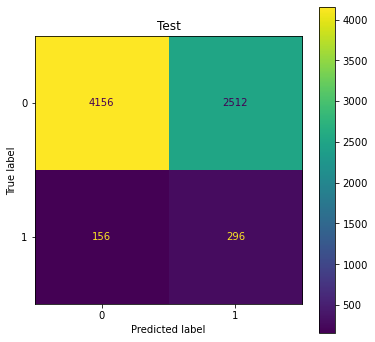

In [58]:
pp_tfidf.fit(X_train_1, y_train_1)

scores(pp_tfidf, X_train_1, y_train_1, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

The scores did not improve very much. In addition, n-grams were slightly more overfitting without this model.

### Model 2: Multinomial Naives Bayes

In [188]:
mnb = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('mnb', MultinomialNB())   
    ])

Train Scores
accuracy:  0.6362126245847176
recall:    0.6872330327479829
Validation Scores
accuracy:  0.5708666947605001
recall:    0.70509977827051
Test Scores
accuracy:  0.5693820224719102
recall:    0.6570796460176991


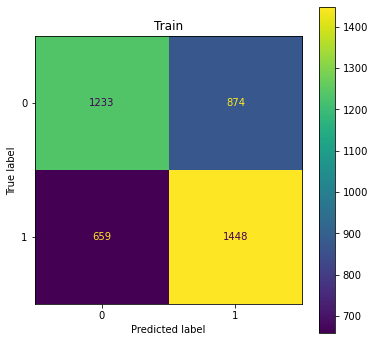

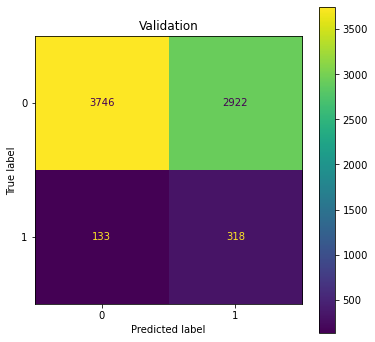

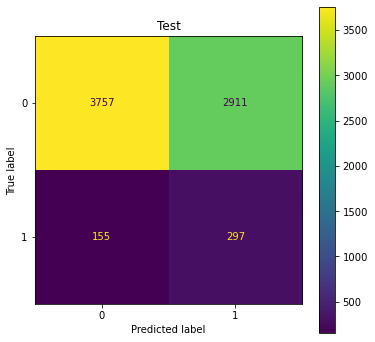

In [189]:
mnb.fit(X_train_1, y_train_1)

scores(mnb, X_train_1, y_train_1, 'Train')
scores(mnb, X_val, y_val, 'Validation')
mnb_acc, mnb_recall = scores(mnb, X_test, y_test, 'Test')

### Model 3: Random Forest

In [138]:
pp_rf = Pipeline(steps=[
    #decreased the number of features to reduce overfitting
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)), 
    ('rf', RandomForestClassifier(random_state=42))   
    ])

In [139]:
grid = {'rf__max_depth': [3,5,8,10],
        'rf__max_features': ['auto', 'sqrt'],
        'rf__min_samples_leaf': [2, 5, 10, 20, 30, 50],
        'rf__min_samples_split': [2, 5, 7, 10, 20, 50]}

In [140]:
gs_rf = GridSearchCV(estimator=pp_rf, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Train Scores
accuracy:  0.7994779307071666
recall:    0.8115804461319411
Validation Scores
accuracy:  0.6191880882146369
recall:    0.6851441241685144
Test Scores
accuracy:  0.6148876404494382
recall:    0.6393805309734514


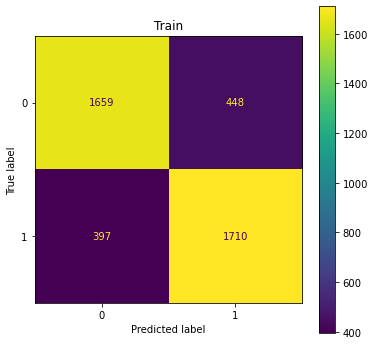

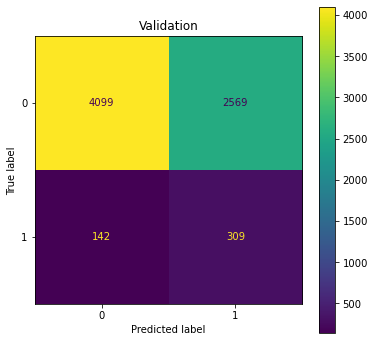

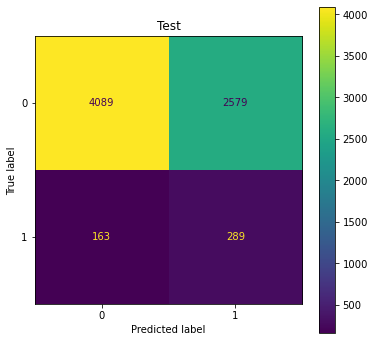

In [141]:
gs_rf.fit(X_train_1, y_train_1)

scores(gs_rf, X_train_1, y_train_1, 'Train')
scores(gs_rf, X_val, y_val, 'Validation')
rf_acc, rf_recall = scores(gs_rf, X_test, y_test, 'Test')

In [142]:
gs_rf.best_params_

{'rf__max_depth': 8,
 'rf__max_features': 'auto',
 'rf__min_samples_leaf': 20,
 'rf__min_samples_split': 2}

In [66]:
"""
{'rf__max_depth': 5,
 'rf__max_features': 'auto',
 'rf__min_samples_leaf': 30,
 'rf__min_samples_split': 2}
"""

"\n{'rf__max_depth': 3,\n 'rf__max_features': 'auto',\n 'rf__min_samples_leaf': 5,\n 'rf__min_samples_split': 20}\n"

In [203]:
pp_rf = Pipeline(steps=[
    #decreased the number of features to reduce overfitting
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=int(0.1*max_feats_1))), 
    ('rf', RandomForestClassifier(random_state=42,
                                  max_depth=3,
                                  max_features='auto',
                                  min_samples_leaf=50,
                                  min_samples_split=50))   
    ])

Train Scores
accuracy:  0.6478405315614618
recall:    0.707641196013289
Validation Scores
accuracy:  0.5371540946762186
recall:    0.6740576496674058
Test Scores
accuracy:  0.5387640449438202
recall:    0.6703539823008849


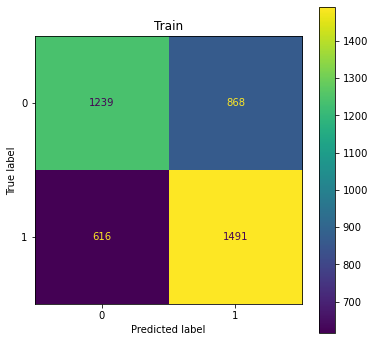

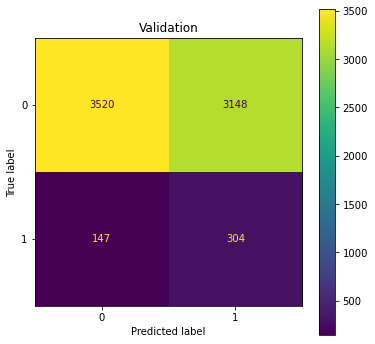

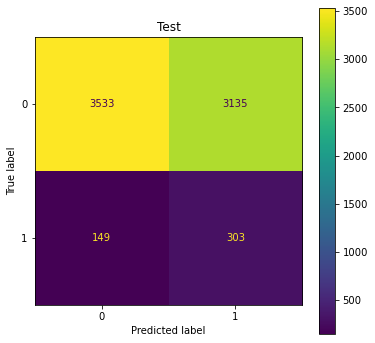

In [204]:
pp_rf.fit(X_train_1, y_train_1)

scores(pp_rf, X_train_1, y_train_1, 'Train')
scores(pp_rf, X_val, y_val, 'Validation')
rf_acc, rf_recall = scores(pp_rf, X_test, y_test, 'Test')

### Model 4: K-Nearest Neighbors

In [207]:
pp_knn = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('knn', KNeighborsClassifier(weights='uniform'))   
    ])

In [208]:
grid = {'knn__n_neighbors': list(range(1, 20, 2)),
        'knn__p': [1,2,3,4]}

In [209]:
gs_knn = GridSearchCV(estimator=pp_knn, 
                      param_grid=grid, 
                      scoring='accuracy', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

Fitting 3 folds for each of 40 candidates, totalling 120 fits


/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.58471981 0.57688573        nan        nan 0.59871862 0.5949208
        nan        nan 0.60204128 0.60370049        nan        nan
 0.61770336 0.61105805        nan        nan 0.6120062  0.61271845
        nan        nan 0.61390604 0.61794162        nan        nan
 0.62078691 0.61865235        nan        nan 0.62078674 0.61604245
        nan        nan 0.62268472 0.6172292         nan        nan
 0.62553457 0.61983876        nan        nan]
  warnings.warn(


Train Scores
accuracy:  0.6753678215472235
recall:    0.6934029425723778
Validation Scores
accuracy:  0.6172215198763872
recall:    0.6895787139689579
Test Scores
accuracy:  0.6084269662921349
recall:    0.6106194690265486


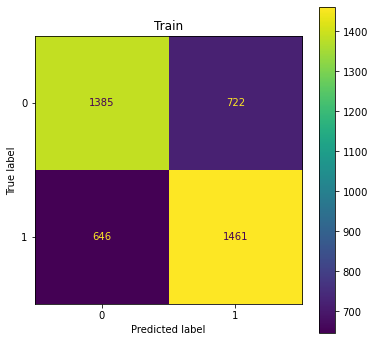

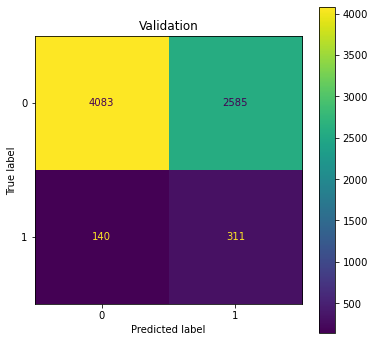

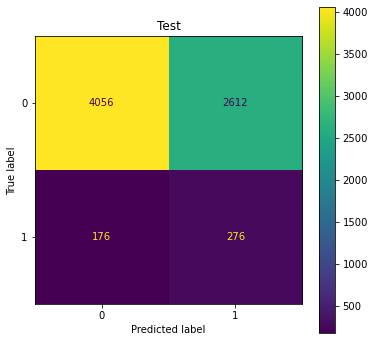

In [210]:
gs_knn.fit(X_train_1, y_train_1)

scores(gs_knn, X_train_1, y_train_1, 'Train')
scores(gs_knn, X_val, y_val, 'Validation')
knn_acc, knn_recall = scores(gs_knn, X_test, y_test, 'Test')

In [160]:
gs_knn.best_params_

{'knn__n_neighbors': 19, 'knn__p': 2}

In [74]:
"""
{'knn__n_neighbors': 17, 'knn__p': 2, 'knn__weights': 'uniform'}
"""

"\n{'knn__n_neighbors': 19, 'knn__p': 2, 'knn__weights': 'uniform'}\n"

In [213]:
pp_knn = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('knn', KNeighborsClassifier(n_neighbors=19,
                                 p=2,
                                 weights='uniform'))   
    ])

Train Scores
accuracy:  0.6706217370669197
recall:    0.7869008068343617
Validation Scores
accuracy:  0.5141171512852929
recall:    0.7228381374722838
Test Scores
accuracy:  0.508567415730337
recall:    0.7234513274336283


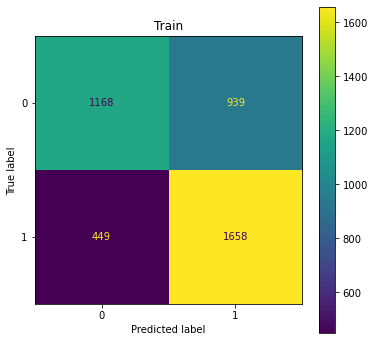

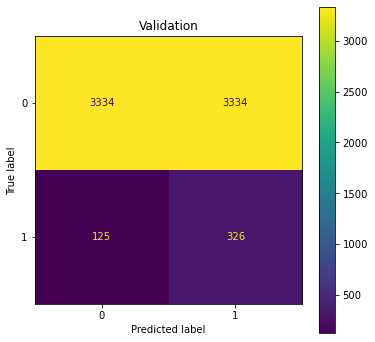

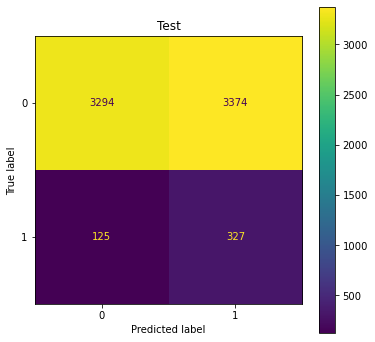

In [214]:
pp_knn.fit(X_train_1, y_train_1)

scores(pp_knn, X_train_1, y_train_1, 'Train')
scores(pp_knn, X_val, y_val, 'Validation')
knn_acc, knn_recall = scores(pp_knn, X_test, y_test, 'Test')

### Model 5: Decision Tree Model

In [77]:
pp_dt = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('dt', DecisionTreeClassifier(random_state=42, criterion='entropy'))   
    ])

In [78]:
grid = {'dt__max_depth': np.arange(1, 17, 3),
        'dt__min_samples_split': np.arange(20, 101, 10),
        'dt__min_samples_leaf': np.arange(20, 101, 10)
       }

In [79]:
gs_dt = GridSearchCV(estimator=pp_dt, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Train Scores
accuracy:  0.6699098243948742
recall:    0.7057427622211675
Validation Scores
accuracy:  0.5677763730861076
recall:    0.6629711751662971
Test Scores
accuracy:  0.5650280898876404
recall:    0.5951327433628318


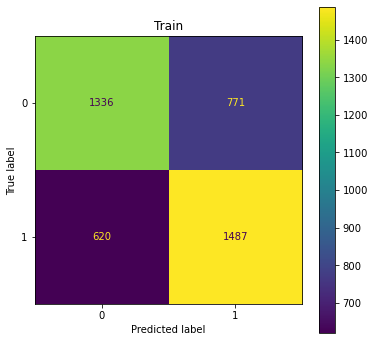

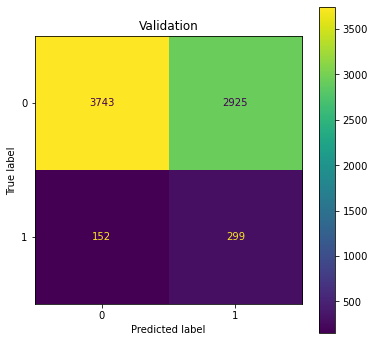

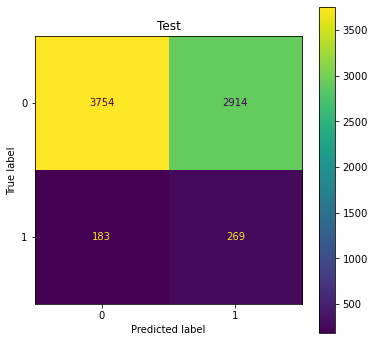

In [80]:
gs_dt.fit(X_train_1, y_train_1)

scores(gs_dt, X_train_1, y_train_1, 'Train')
scores(gs_dt, X_val, y_val, 'Validation')
dt_acc, dt_recall = scores(gs_dt, X_test, y_test, 'Test')

In [81]:
gs_dt.best_params_

{'dt__max_depth': 7, 'dt__min_samples_leaf': 100, 'dt__min_samples_split': 20}

In [82]:
"""
{'dt__max_depth': 7, 'dt__min_samples_leaf': 100, 'dt__min_samples_split': 20}
"""

"\n{'dt__max_depth': 1, 'dt__min_samples_leaf': 20, 'dt__min_samples_split': 20}\n"

In [167]:
pp_dt = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=int(0.1*max_feats_1))),
    ('dt', DecisionTreeClassifier(random_state=42,
                                  criterion='entropy',
                                  max_depth=5,
                                  min_samples_leaf=100,
                                  min_samples_split=20))   
    ])

Train Scores
accuracy:  0.6423825344091125
recall:    0.7432368296155671
Validation Scores
accuracy:  0.4863042562157606
recall:    0.6962305986696231
Test Scores
accuracy:  0.4922752808988764
recall:    0.6880530973451328


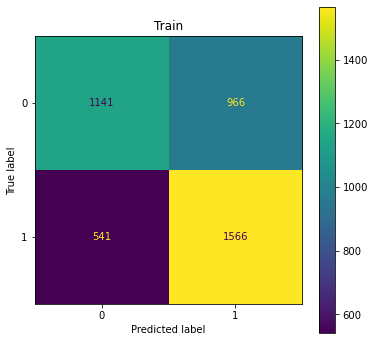

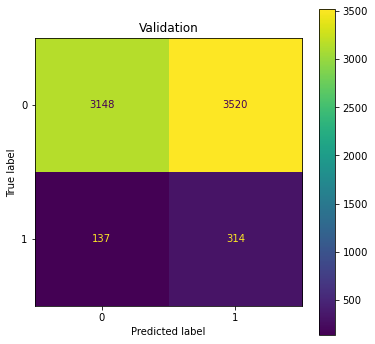

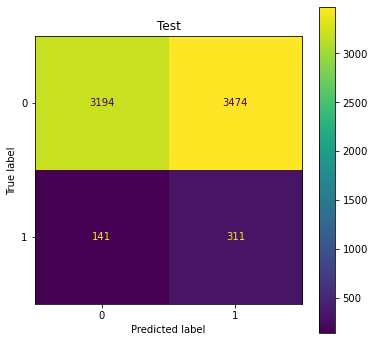

In [168]:
pp_dt.fit(X_train_1, y_train_1)

scores(pp_dt, X_train_1, y_train_1, 'Train')
scores(pp_dt, X_val, y_val, 'Validation')
dt_acc, dt_recall = scores(pp_dt, X_test, y_test, 'Test')

### Model 6: Gradient Boost

In [85]:
pp_gbc = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=int(max_feats_1*0.1))),
    ('gbc', GradientBoostingClassifier(random_state=42))   
    ])

In [86]:
grid = {'gbc__max_features': ['auto','log2'],
        'gbc__min_samples_split':[500, 600, 700, 800, 900, 1000],
        'gbc__min_samples_leaf':[5, 10, 20, 50, 100],
        'gbc__max_depth':[2, 3, 5, 10, 20]
       }

In [87]:
gs_gbc = GridSearchCV(estimator=pp_gbc, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

Fitting 3 folds for each of 300 candidates, totalling 900 fits
Train Scores
accuracy:  0.6874703369719981
recall:    0.7147603227337447
Validation Scores
accuracy:  0.5833684506250878
recall:    0.6762749445676275
Test Scores
accuracy:  0.5811797752808989
recall:    0.6526548672566371


(58.1, 65.3)

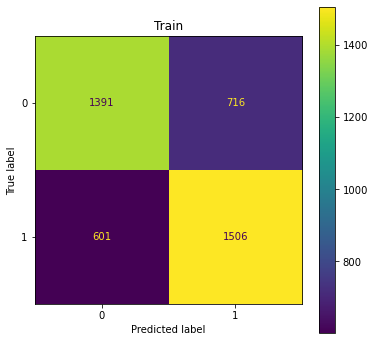

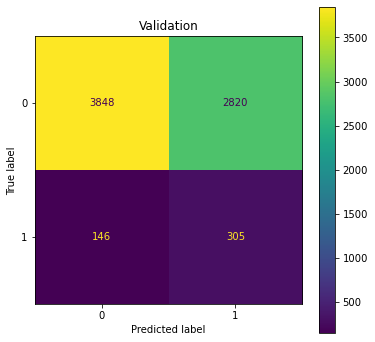

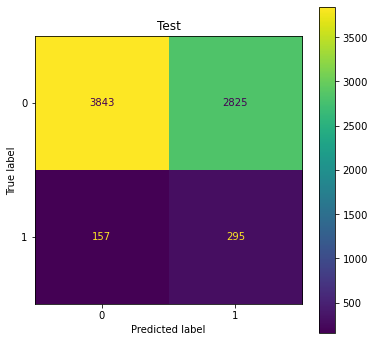

In [88]:
gs_gbc.fit(X_train_1, y_train_1)

scores(gs_gbc, X_train_1, y_train_1, 'Train')
scores(gs_gbc, X_val, y_val, 'Validation')
scores(gs_gbc, X_test, y_test, 'Test')

In [89]:
gs_gbc.best_params_

{'gbc__max_depth': 2,
 'gbc__max_features': 'auto',
 'gbc__min_samples_leaf': 100,
 'gbc__min_samples_split': 500}

In [90]:
"""
{'gbc__max_depth': 3,
 'gbc__max_features': 'auto',
 'gbc__min_samples_split': 1000
"""

"\n{'gbc__max_depth': 3,\n 'gbc__max_features': 'auto',\n 'gbc__min_samples_split': 1000\n"

In [169]:
pp_gbc = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=int(max_feats_1*0.1))),
    ('gbc', GradientBoostingClassifier(random_state=42,
                                       max_depth= 2,
                                       max_features= 'auto',
                                       #I adjusted parameters to decrease overfitting
                                       min_samples_leaf= 100, 
                                       min_samples_split= 500))   
    ])

Train Scores
accuracy:  0.6874703369719981
recall:    0.7147603227337447
Validation Scores
accuracy:  0.5833684506250878
recall:    0.6762749445676275
Test Scores
accuracy:  0.5811797752808989
recall:    0.6526548672566371


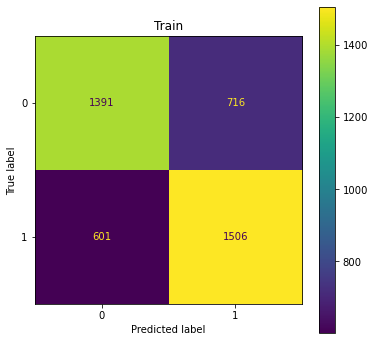

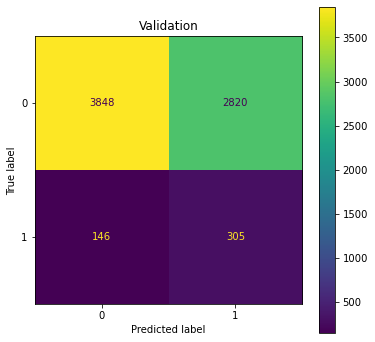

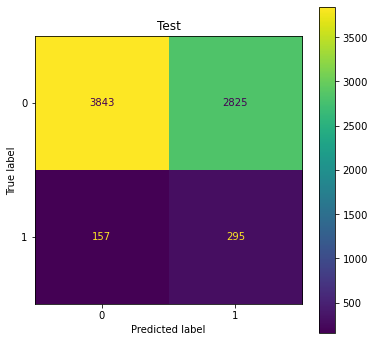

In [170]:
pp_gbc.fit(X_train_1, y_train_1)

scores(pp_gbc, X_train_1, y_train_1, 'Train')
scores(pp_gbc, X_val, y_val, 'Validation')
gbc_acc, gbc_recall = scores(pp_gbc, X_test, y_test, 'Test')

### Model X: Neural Networks

In [93]:
tfidf = TfidfVectorizer(stop_words=sw, max_features=int(max_feats_1))

In [94]:
X_train_1_vec = tfidf.fit_transform(X_train_1)
X_val_vec = tfidf.transform(X_val)
X_test_vec = tfidf.transform(X_test)

In [95]:
np.random.seed(123)
model2 = models.Sequential()
model2.add(layers.Dense(50, activation='relu'))
model2.add(layers.Dense(25, activation='relu'))
model2.add(layers.Dense(7, activation='relu'))
model2.add(layers.Dense(5, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [96]:
X_train_1_vec.shape

(4214, 421)

In [97]:
y_train_1.shape

(4214,)

In [98]:
# model2.compile(optimizer='sgd',
#               loss='categorical_crossentropy',
#               metrics=['acc'])

# history2 = model2.fit(x=X_train_1_vec,
#                       y=y_train_1,
#                       epochs=30,
#                       batch_size=50,
#                      # validation_data=(X_val, y_val)
#                      )

### Model 7: Ensemble

In [174]:
pp_logreg = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

In [175]:
voting_clf = VotingClassifier(estimators={("logreg", pp_logreg),
                                          ("mnb", mnb),
                                          ("rf", pp_rf),
                                          ('knn', pp_knn),
                                          #('dt', pp_dt),
                                          ("gbc", pp_gbc)
                                        },
                              voting= "soft")

Train Scores
accuracy:  0.692453725676317
recall:    0.7546274323682961
Validation Scores
accuracy:  0.5791543756145526
recall:    0.7228381374722838
Test Scores
accuracy:  0.5806179775280899
recall:    0.6858407079646017


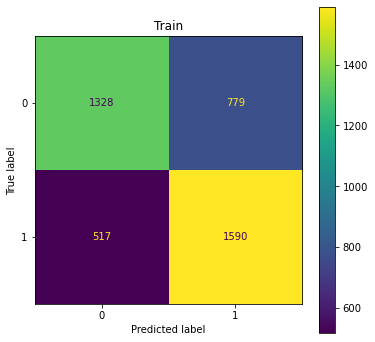

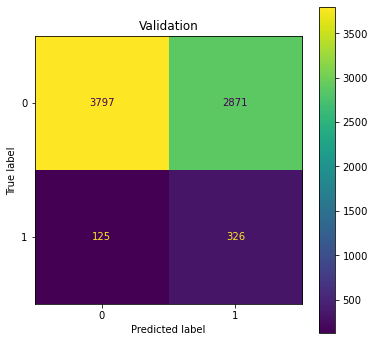

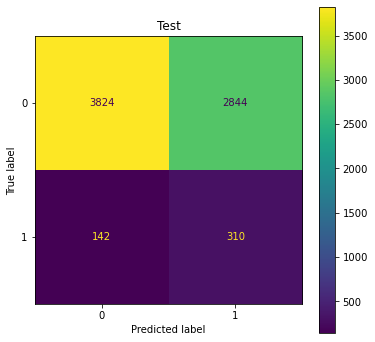

In [176]:
voting_clf.fit(X_train_1, y_train_1)

scores(voting_clf, X_train_1, y_train_1, 'Train')
scores(voting_clf, X_val, y_val, 'Validation')
vot_acc, vot_recall = scores(voting_clf, X_test, y_test, 'Test')

In [205]:
voting_clf = VotingClassifier(estimators={#("logreg", pp_logreg),
                                          ("mnb", mnb),
                                          ("rf", pp_rf),
                                          #('knn', pp_knn),
                                          #('dt', pp_dt),
                                          ("gbc", pp_gbc)
                                        },
                              voting= "soft")

Train Scores
accuracy:  0.669672520170859
recall:    0.7095396298054105
Validation Scores
accuracy:  0.5794353139485883
recall:    0.6762749445676275
Test Scores
accuracy:  0.5818820224719101
recall:    0.6637168141592921


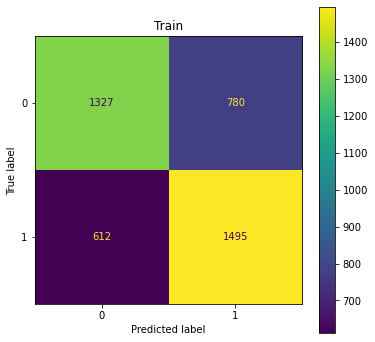

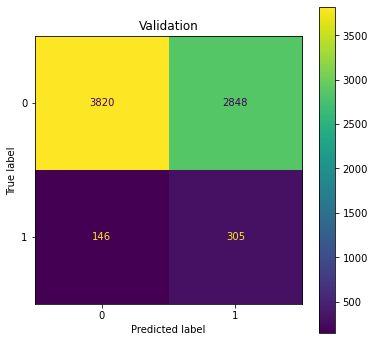

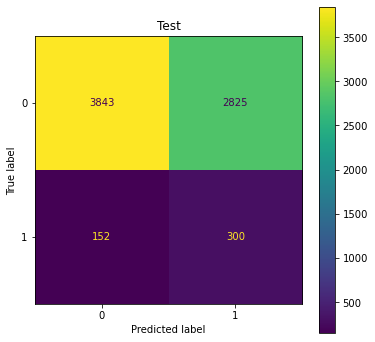

In [206]:
voting_clf.fit(X_train_1, y_train_1)

scores(voting_clf, X_train_1, y_train_1, 'Train')
scores(voting_clf, X_val, y_val, 'Validation')
vot_acc, vot_recall = scores(voting_clf, X_test, y_test, 'Test')

In [177]:
voting_clf = VotingClassifier(estimators={("logreg", pp_logreg),
                                          ("mnb", mnb),
                                          ("rf", pp_rf),
                                          #('knn', pp_knn),
                                          #('dt', pp_dt),
                                          ("gbc", pp_gbc)
                                        },
                              voting= "soft")

In [ ]:
voting_clf.fit(X_train_1, y_train_1)

scores(voting_clf, X_train_1, y_train_1, 'Train')
scores(voting_clf, X_val, y_val, 'Validation')
vot_acc, vot_recall = scores(voting_clf, X_test, y_test, 'Test')

In [ ]:
Train Scores
accuracy:  0.7081158044613194
recall:    0.7588989084005695
Validation Scores
accuracy:  0.5947464531535328
recall:    0.7117516629711752
Test Scores
accuracy:  0.5936797752808989
recall:    0.6637168141592921

## Reviewing All Models:

In [171]:
X_labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6', 'Model 7']
y1 = [log_recall, mnb_recall, rf_recall, knn_recall, dt_recall, gbc_recall, vot_recall]

In [172]:
y2 = [log_acc, mnb_acc, rf_acc, knn_acc, dt_acc, gbc_acc, vot_acc]

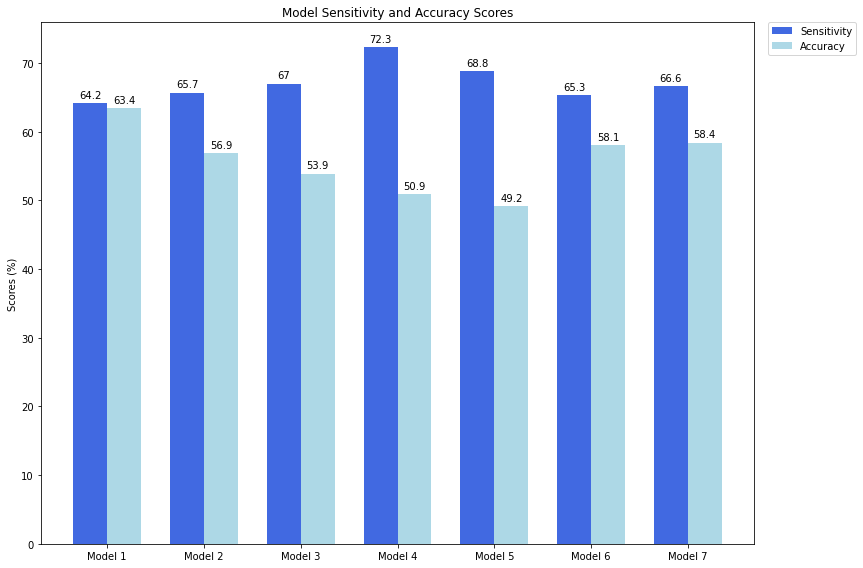

In [173]:
width = 0.35  # the width of the bars
x = np.arange(len(X_labels))
fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, y1, width, label='Sensitivity', color='royalblue')
rects2 = ax.bar(x + width/2, y2, width, label='Accuracy', color='lightblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores (%)')
ax.set_title('Model Sensitivity and Accuracy Scores')
ax.set_xticks(x)
ax.set_xticklabels(X_labels)
ax.legend(bbox_to_anchor=(1.15, 1.01))

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()
#save the figure in the images folder
fig.savefig('images/Model_Scores.png', bbox_inches='tight')

## Setting Final Model

In [105]:
#split the positive and negative data
df_pos = df[df['READMISSION']==1]
df_neg = df[df['READMISSION']==0]

In [106]:
#take a sample of the negative training set with the same number of rows as positive dataset
df_neg_samp = df_neg.sample(n=len(df_pos), random_state=42)

In [107]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_df = pd.concat([df_pos,df_neg_samp],axis=0)

In [108]:
#randomize the new dataset
new_df = new_df.sample(n=len(new_df), random_state=42)

In [109]:
#split out the X and y of the new dataset
new_y = new_df['READMISSION']
new_X = new_df['TEXT']
new_max_feats = int(new_X.shape[0]*0.10)

In [110]:
final_model = voting_clf

Final Scores
accuracy:  0.608452900153804
recall:    0.7335548172757476


KeyboardInterrupt: 

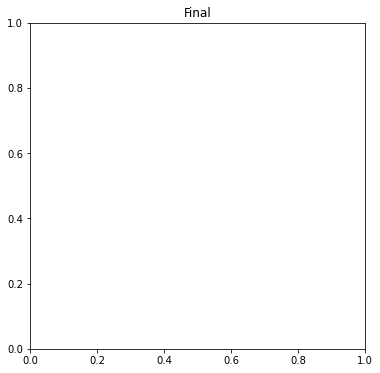

In [111]:
final_model.fit(new_X, new_y)
final_acc, final_recall = scores(final_model, X, y, 'Final')

In [ ]:
y_preds = final_model.predict(X)
y_probs = final_model.predict_proba(X)

In [ ]:
y_preds = pd.DataFrame(y_preds)
y_probs = pd.DataFrame(y_probs)

In [ ]:
y_probs.drop(0, axis=1, inplace=True)

## Merging Results to Other Features and Exporting Data

In [ ]:
new_df1 = df.copy()
new_df2 = df.copy()

new_df1 = new_df1.merge(y_preds, left_index=True, right_index=True)
new_df1.drop('TEXT', axis=1, inplace=True)
new_df1.rename(columns={0: 'TEXT'}, inplace=True)
                        
new_df2 = new_df2.merge(y_probs, left_index=True, right_index=True)
new_df2.drop('TEXT', axis=1, inplace=True)
new_df2.rename(columns={1: 'TEXT'}, inplace=True)

In [ ]:
#export the modified dataframe with predicted classifications to the data folder
new_df1.to_csv("data/admissions_nlp_processed_3.csv.gz" , index = False,compression='gzip')

In [ ]:
#export the modified dataframe with predicted probabilites to the data folder
new_df2.to_csv("data/admissions_nlp_processed_4.csv.gz" , index = False,compression='gzip')